In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# generate data

In [2]:
# In real world, you cannot learn how the data was generated. So do not rely on this function when coding your lab.
def generate_data(dim, num):
    x = np.random.normal(0, 10, [num, dim])
    coef = np.random.uniform(-1, 1, [dim, 1])
    pred = np.dot(x, coef)
    pred_n = (pred - np.mean(pred)) / np.sqrt(np.var(pred))
    label = np.sign(pred_n)
    mislabel_value = np.random.uniform(0, 1, num)
    mislabel = 0
    for i in range(num):
        if np.abs(pred_n[i]) < 1 and mislabel_value[i] > 0.9 + 0.1 * np.abs(pred_n[i]):
            label[i] *= -1
            mislabel += 1
    return x, label, mislabel/num

mr:0.034


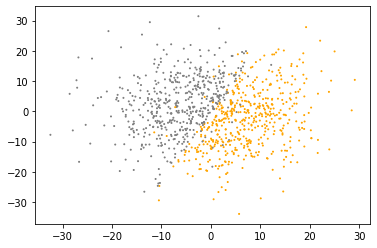

In [3]:
# example
X, y ,mr=generate_data(2,1000)
print("mr:" + str(mr))

color = []
for i in y:
    if i == 1:
        color.append('gray')
    else:
        color.append('orange') 
plt.scatter(X.T[0],X.T[1],1,color)

# write your model class

In [4]:
class SVM:
    def __init__(self, dim):
        self.w = np.zeros(dim)
        self.b = 0.0
    
    def drop_error(self, X, y, q):
        num = y.size
        dim = X[0].size
        drop = []
        for i in range(num):
            max_same = 0
            max_diff = 0
            for j in np.random.choice(num, q):
                if j != i:
                    temp = np.sum(np.abs(X[i] - X[j]))
                    if y[j] == y[i]:
                        if temp > max_same:
                            max_same = temp
                    else:
                        if temp > max_diff:
                            max_diff = temp
            if max_diff < max_same:
                drop.append(i)
        X = np.delete(X, drop, axis = 0)
        y = np.delete(y, drop)
        return X, y

    def predict(self, X):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """
        y_p = []
        for i in range(X.shape[0]):
            if (np.dot(X[i],self.w) + self.b > 0):
                y_p.append(1)
            else:
                y_p.append(-1)
        return np.array(y_p)         

In [5]:
# you can do anything necessary about the model
class SVM1(SVM):
    
    def z(self, x, y):
        return y * (np.dot(self.w, x) + self.b)
    
    def hinge_loss(self, X, y):
        loss = np.dot(self.w, self.w) / 2.0
        for i in range(y.size):
            loss += self.soft * max(0, 1 - self.z(X[i], y[i]))
        return loss

    def hinge_grad_loss(self, X, y):
        gradw = self.w
        gradb = 0
        for i in range(y.size):
            if (self.z(X[i], y[i]) < 1):
                gradw = gradw - self.soft * y[i] * X[i]
                gradb -= self.soft * y[i]
        return gradw, gradb

    def exp_loss(self, X, y):
        loss = np.dot(self.w, self.w) / 2.0
        for i in range(y.size):
            loss += self.soft * np.exp(-self.z(X[i], y[i]))
        return loss

    def exp_grad_loss(self, X, y):
        gradw = self.w
        gradb = 0
        for i in range(y.size):
            gradw = gradw - self.soft * np.exp(-self.z(X[i], y[i])) * y[i] * X[i]
            gradb -= self.soft * np.exp(-self.z(X[i], y[i])) * y[i]
        return gradw, gradb
    
    def log_loss(self, X, y):
        loss = np.dot(self.w, self.w) / 2.0
        for i in range(y.size):
            loss += self.soft * np.log(1 + np.exp(-self.z(X[i], y[i])))
        return loss

    def log_grad_loss(self, X, y):
        gradw = self.w
        gradb = 0
        for i in range(y.size):
            gradw = gradw - self.soft / (1 + np.exp(self.z(X[i], y[i]))) * y[i] * X[i]
            gradb -= self.soft / (1 + np.exp(self.z(X[i], y[i]))) * y[i]
        return gradw, gradb
    
    def fit(self, X, y, soft=2, soft_method="hinge", lr=1e-5, iter=1e3, if_drop=False, if_draw=False):
        """
        Fit the coefficients via your methods
        """
        if soft_method not in ["hinge", "exp", "log"]:
            print("soft method error")
            return

        if (if_drop):
            X, y =  self.drop_error(X, y, 100)
        
        self.soft = soft

        loss = []
        for i in range(int(iter)):
            if soft_method == "hinge":
                if if_draw: loss.append(self.hinge_loss(X, y))
                gradw, gradb = self.hinge_grad_loss(X, y)
            elif soft_method == "exp":
                if if_draw: loss.append(self.exp_loss(X, y))
                gradw, gradb = self.exp_grad_loss(X, y)
            else:
                if if_draw: loss.append(self.log_loss(X, y))
                gradw, gradb = self.log_grad_loss(X, y)
            self.w -= lr * gradw
            self.b -= lr * gradb
        return loss

In [6]:
# you can do anything necessary about the model
class SVM2(SVM):

    def construct_predict(self, X, y, lam, C):
        num = y.size
        u = np.zeros(num)
        for i in range(num):
            u[i] = np.dot(self.w, X[i])
        
        count = 0
        self.b = 0
        for i in range(num):
            if lam[i] > 0 and lam[i] < C:
                self.b += y[i] - u[i]
                count += 1
        if count:
            self.b /= float(count)
        
        return u + self.b

    def count_loss(self, u, y, lam):
        loss = np.dot(self.w, self.w)/2.0
        for i in range(y.size):
            loss += lam[i] * (1 - y[i] * u[i])
        return loss

    def fit(self, X, y, C=2.0, choose_method="turning", iter=1e3, if_drop=False, if_draw=False):
        """
        Fit the coefficients via your methods
        """
        if choose_method not in ["turning", "random", "maxerr"]:
            print("choose method error")
            return

        if (if_drop):
            X, y =  self.drop_error(X, y, 100)

        loss = []
        num = y.size
        lam = np.zeros(num)
        
        pos = 0
        neg = 0
        for i in range(num):
            if y[i] == 1:
                pos += 1
            else:
                neg += 1
        
        for i in range(num):
            if y[i] == 1:
                lam[i] = C / float(pos)
            else:
                lam[i] = C / float(neg)
        
        a1 = 0

        self.w = np.zeros(X[0].size)
        for i in range(num):
            self.w = self.w + lam[i] * y[i] * X[i]

        for _ in range(int(iter)):
            u = self.construct_predict(X, y, lam, C)
            if if_draw: loss.append(self.count_loss(u, y, lam))  
            
            if (choose_method == "maxerr"):
                m = 0
                a1 = -1
                for j in range(num):
                    if lam[a1] > 0 and lam[a1] < C:
                        temp = abs(u[j]*y[j] - 1)
                    elif lam[a1] == 0:
                        temp = 1 - u[j]*y[j]
                    else:
                        temp = u[j]*y[j] - 1
                    if temp > m:
                        m = temp
                        a1 = j
                if a1 == -1:
                    return loss
            else:
                count = 0
                if (choose_method == "turning"):
                        a1 = (a1 + 1) % num
                else:
                    a1 = np.random.randint(num)
                while (lam[a1] > 0 and lam[a1] < C and abs(u[a1]*y[a1] - 1) < 1e-6)\
                    or (lam[a1] == 0 and u[a1]*y[a1] >= 1)\
                    or (lam[a1] == C and u[a1]*y[a1] <= 1):
                    if (choose_method == "turning"):
                        a1 = (a1 + 1) % num
                    else:
                        a1 = np.random.randint(num)
                    count += 1
                    if count == num:
                        return loss

            e1 = u[a1] - y[a1]
            
            m = 0
            a2 = -1
            for j in range(num):    
                e2 = u[j] - y[j]
                de = e1 - e2
                if abs(de) > abs(m):
                    a2 = j
                    m = de
            if (a2 == -1):
                return loss

            sum = lam[a1] * y[a1] + lam[a2] * y[a2]
            lam2new = lam[a2] + y[a2] * m / np.dot(X[a1]-X[a2],X[a1]-X[a2])

            if y[a1] == y[a2]:
                l = max(0, lam[a2] + lam[a1] - C)
                h = min(lam[a1] + lam[a2], C)
            else:
                l = max(0, lam[a2] - lam[a1])
                h = min(C + lam[a2] - lam[a1], C)

            self.w = self.w - lam[a2] * y[a2] * X[a2] - lam[a1] * y[a1] * X[a1]
            
            lam[a2] = min(max(lam2new, l), h)
            lam[a1] = (sum - lam[a2] * y[a2]) * y[a1]

            self.w = self.w + lam[a2] * y[a2] * X[a2] + lam[a1] * y[a1] * X[a1]

        return loss


# construct and train your models

In [7]:
# generate data
# X_data, y_data, mislabel = generate_data()
from sympy import true


dim, size = 20, 10000

X, y, mislabel = generate_data(dim, size)
y = y.ravel()
print("mislabel: " + str(mislabel))

# split data
index = np.random.permutation(y.size)
X = X[index]
y = y[index]
t = (int)(6 * size / 10)
X_train = X[0:t, :]
X_test = X[t:size, :]
y_train = y[0:t]
y_test = y[t:size]

# constrcut model and train (remember record time)
# model1 = SVM1()
# model1.fit()

m1 = SVM1(dim)
t1 = time.perf_counter()
loss1 = m1.fit(X_train, y_train, if_draw=True)
t2 = time.perf_counter()
print("model 1 time: " + str(t2 - t1))

m2 = SVM2(dim)
t1 = time.perf_counter()
loss2 = m2.fit(X_train, y_train, if_draw=True)
t2 = time.perf_counter()
print("model 2 time: " + str(t2 - t1))

mislabel: 0.0351
model 1 time: 26.70337329999984
model 2 time: 18.364852600000177


# predict and compare your results

model 1 acc: 0.951
model 2 acc: 0.942
prediction similarity: 0.96


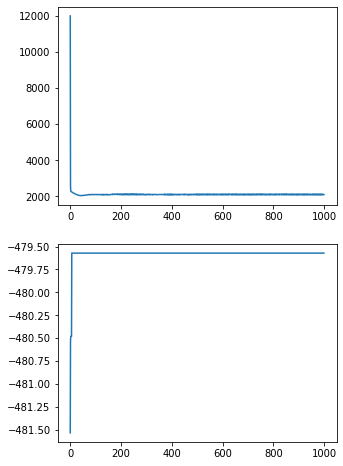

In [9]:
# make prediction
# pred = model1.predict()
pred1 = m1.predict(X_test)
pred2 = m2.predict(X_test)

# compared with answer
acc1 = 1 - np.sum(np.abs(pred1 - y_test))/(2.0 * y_test.size)
acc2 = 1 - np.sum(np.abs(pred2 - y_test))/(2.0 * y_test.size)
sim = 1 - np.sum(np.abs(pred2 - pred1))/(2.0 * y_test.size)

# compare each methods
print("model 1 acc: " + str(acc1))
print("model 2 acc: " + str(acc2))
print("prediction similarity: " + str(sim))
plt.figure(figsize=(5, 8))
plt.sca(plt.subplot(2,1,1))
plt.plot(loss1)
plt.sca(plt.subplot(2,1,2))
plt.plot(loss2)